In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
!pip install keras_preprocessing
import os
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import cifar100
!pip install wandb
import wandb
from wandb.keras import WandbCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


Ladislav Gaža

Matej Kuráň

Wandb report:
https://wandb.ai/nsiete23-gaza-kuran/Nsiete_zadanie2_cifar/reports/Zadanie-2-Cifar-100--Vmlldzo0MDM2NDI1

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Changelog: We use 100 classes. Commented code in the cell bellow is parameter for load_data() if you want to load 20 superclasses.

In [3]:
(X, y), (test_X, test_y) = cifar100.load_data() # label_mode='coarse'
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_val: ' + str(val_X.shape))
print('Y_val: ' + str(val_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

169001437/169001437 [==============================] - 2s 0us/step
X_train: (40000, 32, 32, 3)
Y_train: (40000, 1)
X_val: (10000, 32, 32, 3)
Y_val: (10000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


In [4]:
uniques = np.unique(train_y, return_counts=True, return_index=True)

Every class contains 400 images in the training dataset.

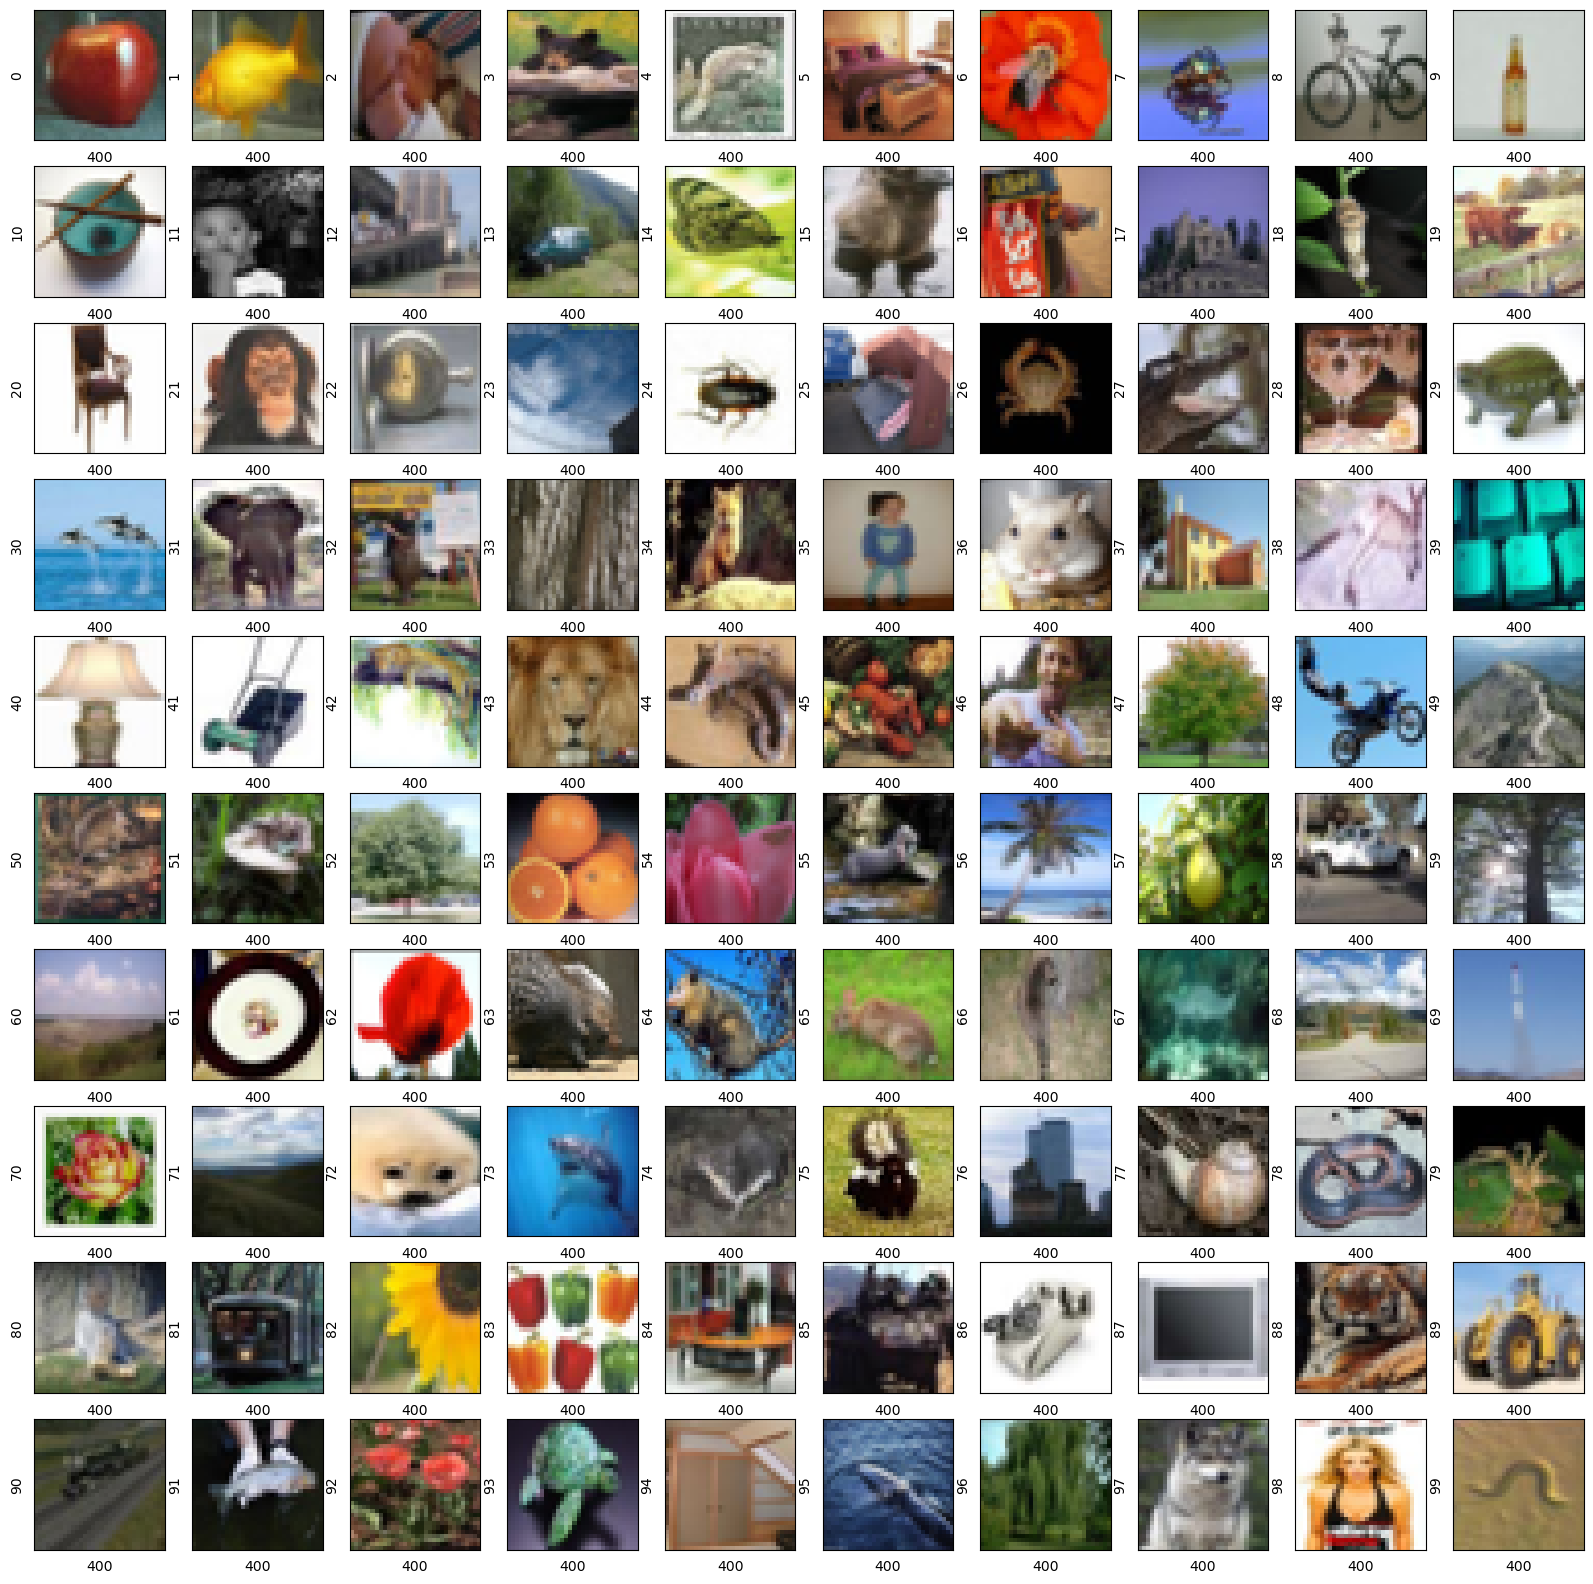

In [5]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_X[uniques[1][i], :])
    plt.ylabel(uniques[0][i])
    plt.xlabel(uniques[2][i])

Changelog: We tried to use better techniques for whitening/denoising images but it yielded worse results than not using it at all.

In [14]:
import cv2

with tf.device('/gpu:0'):
    denoised_train_X = train_X.copy()
    for i in range(train_X.shape[0]):
        print(i, end="\r")
        denoised_train_X[i] = cv2.fastNlMeansDenoisingColored(denoised_train_X[i], None, 10, 5, 3, 5)
    denoised_val_X = val_X.copy()
    for j in range(val_X.shape[0]):
        print(j, end="\r")
        denoised_val_X[j] = cv2.fastNlMeansDenoisingColored(denoised_val_X[j], None, 10, 5, 3, 5)
    denoised_test_X = test_X.copy()
    for k in range(test_X.shape[0]):
        print(k, end="\r")
        denoised_test_X[k] = cv2.fastNlMeansDenoisingColored(denoised_test_X[k], None, 10, 5, 3, 5)

In [6]:
IMG_PX_SIZE = 32
train_X = train_X.reshape(train_X.shape[0], IMG_PX_SIZE, IMG_PX_SIZE, 3).astype('float32')
val_X = val_X.reshape(val_X.shape[0], IMG_PX_SIZE, IMG_PX_SIZE, 3).astype('float32')
test_X = test_X.reshape(test_X.shape[0], IMG_PX_SIZE, IMG_PX_SIZE, 3).astype('float32')
train_X = train_X / 255.0
val_X = val_X / 255.0
test_X = test_X / 255.0

We coppied denoised images to other variables just to visualize the effect. We did not use denoised data for training in the end because it decreased accuracy of the model. 

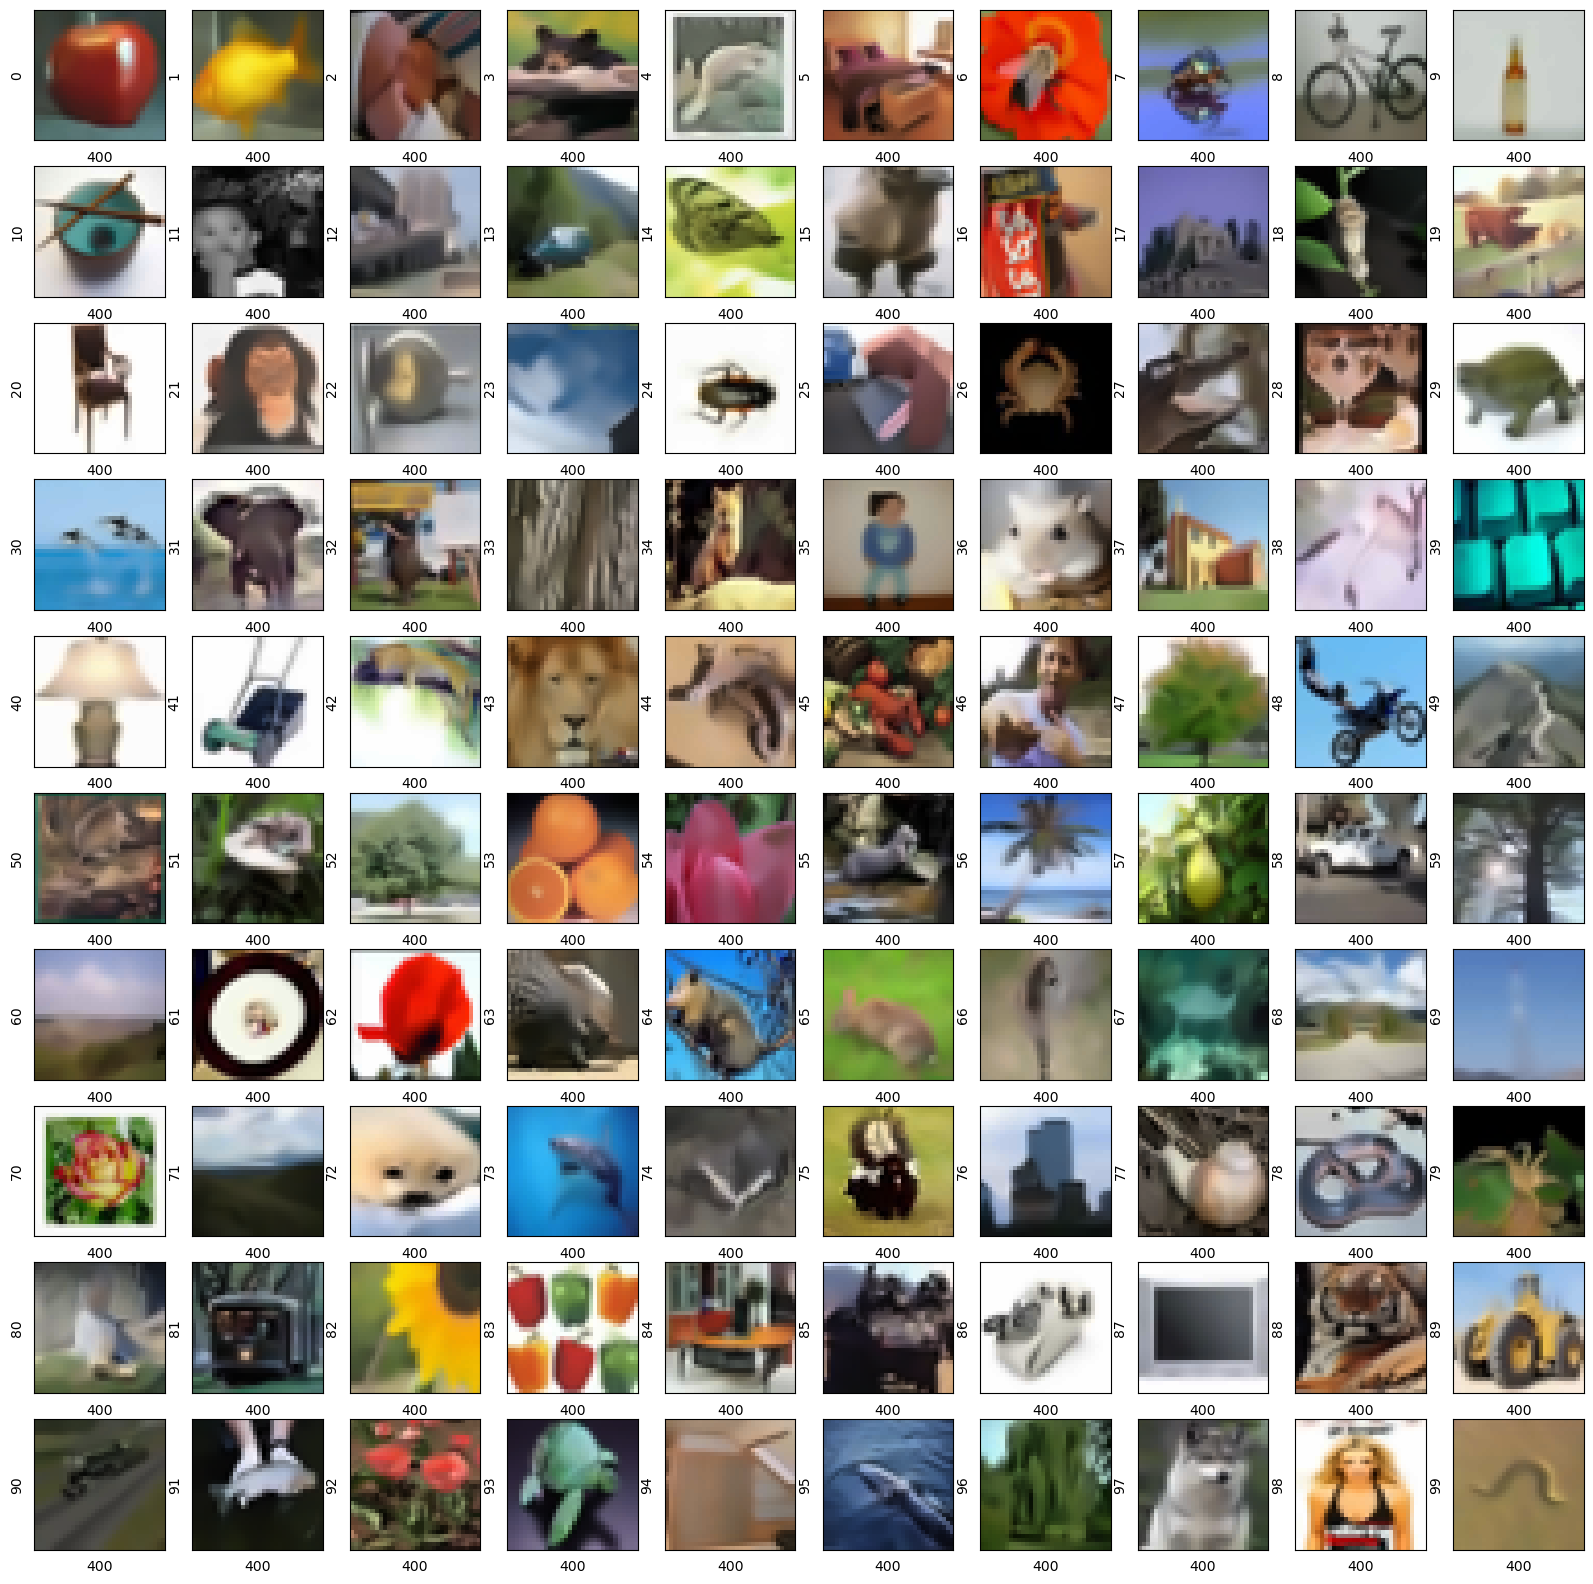

In [19]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(denoised_train_X[uniques[1][i], :])
    plt.ylabel(uniques[0][i])
    plt.xlabel(uniques[2][i])

Within image augmentation we tried different techniques and this one worked the best. Commented augmentatios are the ones that we tried but did not use in the end.

In [7]:
BATCH = 256

training_datagen = ImageDataGenerator(
    # horizontal_flip=True,
    # vertical_flip=True,
    rotation_range=20,
    zoom_range=[0.8, 1.2],
    # target_size=(32, 32)
    width_shift_range=0.1,
    height_shift_range=0.1,
    # brightness_range=[0.9, 1.1]
)
train_generator = training_datagen.flow(train_X,
                                        tf.reshape(train_y, (-1)), 
                                        batch_size=BATCH,
                                        shuffle=True
                                        )

Everything related to sweep config is commented down below. 

Changelog: Automated hyperparameter tuning - gridsearch.

In [23]:
#uncomment for sweep config

# sweep_config = {
#     'name': 'zadanie2_sweep',
#     'method': 'grid',
#     'metric': {
#         'name': 'accuracy',
#         'goal': 'maximize',
#         },
#         'parameters': {
#             'optimizer_learning_rate': {
#                 'values': [0.0001 ,0.001, 0.005],
#             },
#             'regularizer_learning_rate': {
#                 'values': [0.000001, 0.00001, 0.0001 ,0.001],
#             },
#             'dropout_rate': {
#                 'values': [0.1, 0.2, 0.3],
#             },
#             'dense_dropout_rate': {
#                 'values': [0.5, 0.6],
#             }
#         }
#     }

In [8]:
wandb.login()
# sweep_id = wandb.sweep(sweep_config, entity="nsiete23-gaza-kuran", project="Nsiete_zadanie2_cifar")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Changelog - network architecture.

Old model:
```
tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE), input_shape=(IMG_PX_SIZE, IMG_PX_SIZE, 3)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(2,2),
      
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(2,2),
      
tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(2,2),
      
tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(1024, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dropout(DROPOUT_RATE),
tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
tf.keras.layers.Dense(20, activation='softmax')
```
Old model contained 11 milion parameters and had barely 50% accuracy most of the time. Final image size was 1x1.

Wandb run as an example with this giant model: https://wandb.ai/nsiete23-gaza-kuran/Nsiete_zadanie2_cifar/runs/a18k8kbo


We changed the model completely and the most recent and the best version we tried is in the cell below. We experimented with number of convolutional layers in each block and number of filters and also with stride and padding, dense layers and number of neurons in each layer. We also experimented with different dropouts and we ended up with having two dropout rates.

We experimented with early stopping between 5 and 10 epochs.


In [17]:
# def train_sweep():
wandb.init(project="Nsiete_zadanie2_cifar")

IMG_PX_SIZE = 32

EPOCHS = 100
OPTIMIZER_LEARNING_RATE = 0.001
REGULARIZER_LEARNING_RATE = 0.000001 
DROPOUT_RATE = 0.3
DENSE_DROPOUT_RATE = 0.5

wandb.config.batch_size = BATCH
wandb.config.epochs = EPOCHS
wandb.config.optimizer_learning_rate = OPTIMIZER_LEARNING_RATE
wandb.config.regularizer_learning_rate = REGULARIZER_LEARNING_RATE
wandb.config.dropout_rate = DROPOUT_RATE
wandb.config.dense_dropout_rate = DENSE_DROPOUT_RATE

config = wandb.config

with tf.device('/gpu:0'):   # comment this line and shift+tab everything below in the cell if you want to use sweep
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate), input_shape=(IMG_PX_SIZE, IMG_PX_SIZE, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(config.dropout_rate),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(config.dense_dropout_rate),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(config.dense_dropout_rate),

        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(config.dense_dropout_rate),

        tf.keras.layers.Dense(100, activation='softmax')
      ])

    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.optimizer_learning_rate)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(train_generator, epochs=config.epochs, batch_size=config.batch_size, validation_data = (val_X,val_y), shuffle=True, verbose = 1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),WandbCallback()])

    test_loss, test_acc = model.evaluate(test_X, test_y, verbose=2)

    wandb.log({"test_loss": test_loss, "test_acc": test_acc})

accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇████████████
val_loss,█▇▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.63098
best_epoch,31
best_val_loss,1.56293
epoch,37


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_58 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_59 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_60 (Bat  (None, 32, 32, 64)      

2023-04-11 23:08:32.311255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - ETA: 0s - loss: 4.6246 - accuracy: 0.0681

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.5s


157/157 [==============================] - 38s 195ms/step - loss: 4.6246 - accuracy: 0.0681 - val_loss: 6.0716 - val_accuracy: 0.0147
Epoch 2/100
157/157 [==============================] - 24s 151ms/step - loss: 3.8353 - accuracy: 0.1388 - val_loss: 6.1094 - val_accuracy: 0.0230
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 3.5288 - accuracy: 0.1853

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 194ms/step - loss: 3.5288 - accuracy: 0.1853 - val_loss: 4.3313 - val_accuracy: 0.0868
Epoch 4/100
157/157 [==============================] - ETA: 0s - loss: 3.2776 - accuracy: 0.2244

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 190ms/step - loss: 3.2776 - accuracy: 0.2244 - val_loss: 3.3763 - val_accuracy: 0.2234
Epoch 5/100
157/157 [==============================] - ETA: 0s - loss: 3.1107 - accuracy: 0.2542

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 31s 195ms/step - loss: 3.1107 - accuracy: 0.2542 - val_loss: 3.1427 - val_accuracy: 0.2593
Epoch 6/100
157/157 [==============================] - ETA: 0s - loss: 2.9257 - accuracy: 0.2859

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 31s 197ms/step - loss: 2.9257 - accuracy: 0.2859 - val_loss: 2.7074 - val_accuracy: 0.3227
Epoch 7/100
157/157 [==============================] - ETA: 0s - loss: 2.7997 - accuracy: 0.3109

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 192ms/step - loss: 2.7997 - accuracy: 0.3109 - val_loss: 2.4580 - val_accuracy: 0.3707
Epoch 8/100
157/157 [==============================] - 24s 155ms/step - loss: 2.6369 - accuracy: 0.3404 - val_loss: 3.5775 - val_accuracy: 0.3463
Epoch 9/100
157/157 [==============================] - 24s 150ms/step - loss: 2.5503 - accuracy: 0.3576 - val_loss: 2.5089 - val_accuracy: 0.3827
Epoch 10/100
157/157 [==============================] - ETA: 0s - loss: 2.4662 - accuracy: 0.3752

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 191ms/step - loss: 2.4662 - accuracy: 0.3752 - val_loss: 2.3039 - val_accuracy: 0.4105
Epoch 11/100
157/157 [==============================] - ETA: 0s - loss: 2.3576 - accuracy: 0.3989

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 29s 188ms/step - loss: 2.3576 - accuracy: 0.3989 - val_loss: 2.1790 - val_accuracy: 0.4387
Epoch 12/100
157/157 [==============================] - 24s 153ms/step - loss: 2.2906 - accuracy: 0.4113 - val_loss: 2.2037 - val_accuracy: 0.4435
Epoch 13/100
157/157 [==============================] - ETA: 0s - loss: 2.2254 - accuracy: 0.4247

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 190ms/step - loss: 2.2254 - accuracy: 0.4247 - val_loss: 2.1322 - val_accuracy: 0.4429
Epoch 14/100
157/157 [==============================] - ETA: 0s - loss: 2.1883 - accuracy: 0.4306

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 31s 195ms/step - loss: 2.1883 - accuracy: 0.4306 - val_loss: 2.1101 - val_accuracy: 0.4618
Epoch 15/100
157/157 [==============================] - ETA: 0s - loss: 2.1094 - accuracy: 0.4413

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 31s 196ms/step - loss: 2.1094 - accuracy: 0.4413 - val_loss: 1.9797 - val_accuracy: 0.4837
Epoch 16/100
157/157 [==============================] - 24s 153ms/step - loss: 2.0289 - accuracy: 0.4606 - val_loss: 2.0883 - val_accuracy: 0.4595
Epoch 17/100
157/157 [==============================] - ETA: 0s - loss: 1.9676 - accuracy: 0.4711

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 192ms/step - loss: 1.9676 - accuracy: 0.4711 - val_loss: 1.8942 - val_accuracy: 0.5033
Epoch 18/100
157/157 [==============================] - 23s 148ms/step - loss: 1.9010 - accuracy: 0.4824 - val_loss: 1.9585 - val_accuracy: 0.4946
Epoch 19/100
157/157 [==============================] - ETA: 0s - loss: 1.8445 - accuracy: 0.4970

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 29s 188ms/step - loss: 1.8445 - accuracy: 0.4970 - val_loss: 1.8712 - val_accuracy: 0.5000
Epoch 20/100
157/157 [==============================] - 24s 153ms/step - loss: 1.8170 - accuracy: 0.5002 - val_loss: 1.9224 - val_accuracy: 0.4997
Epoch 21/100
157/157 [==============================] - ETA: 0s - loss: 1.7552 - accuracy: 0.5167

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 190ms/step - loss: 1.7552 - accuracy: 0.5167 - val_loss: 1.7411 - val_accuracy: 0.5358
Epoch 22/100
157/157 [==============================] - 24s 150ms/step - loss: 1.7246 - accuracy: 0.5235 - val_loss: 1.8729 - val_accuracy: 0.5100
Epoch 23/100
157/157 [==============================] - 23s 143ms/step - loss: 1.6769 - accuracy: 0.5334 - val_loss: 1.7491 - val_accuracy: 0.5397
Epoch 24/100
157/157 [==============================] - 23s 148ms/step - loss: 1.6385 - accuracy: 0.5451 - val_loss: 1.7469 - val_accuracy: 0.5400
Epoch 25/100
157/157 [==============================] - 23s 147ms/step - loss: 1.6204 - accuracy: 0.5489 - val_loss: 1.9532 - val_accuracy: 0.5195
Epoch 26/100
157/157 [==============================] - 24s 150ms/step - loss: 1.5780 - accuracy: 0.5608 - val_loss: 1.7926 - val_accuracy: 0.5384
Epoch 27/100
157/157 [==============================] - ETA: 0s - loss: 1.5481 - accuracy: 0.5664

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.7s


157/157 [==============================] - 29s 186ms/step - loss: 1.5481 - accuracy: 0.5664 - val_loss: 1.7186 - val_accuracy: 0.5550
Epoch 28/100
157/157 [==============================] - ETA: 0s - loss: 1.5348 - accuracy: 0.5712

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 30s 193ms/step - loss: 1.5348 - accuracy: 0.5712 - val_loss: 1.6777 - val_accuracy: 0.5574
Epoch 29/100
157/157 [==============================] - 24s 150ms/step - loss: 1.4949 - accuracy: 0.5795 - val_loss: 1.9701 - val_accuracy: 0.5217
Epoch 30/100
157/157 [==============================] - 23s 148ms/step - loss: 1.4824 - accuracy: 0.5846 - val_loss: 1.7277 - val_accuracy: 0.5495
Epoch 31/100
157/157 [==============================] - 23s 147ms/step - loss: 1.4468 - accuracy: 0.5893 - val_loss: 1.7177 - val_accuracy: 0.5605
Epoch 32/100
156/157 [============================>.] - ETA: 0s - loss: 1.4184 - accuracy: 0.5954

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.6s


157/157 [==============================] - 29s 187ms/step - loss: 1.4181 - accuracy: 0.5955 - val_loss: 1.6051 - val_accuracy: 0.5761
Epoch 33/100
157/157 [==============================] - 24s 153ms/step - loss: 1.4008 - accuracy: 0.6037 - val_loss: 1.6142 - val_accuracy: 0.5715
Epoch 34/100
157/157 [==============================] - 23s 146ms/step - loss: 1.3880 - accuracy: 0.6061 - val_loss: 1.6480 - val_accuracy: 0.5698
Epoch 35/100
157/157 [==============================] - ETA: 0s - loss: 1.3883 - accuracy: 0.6094

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230411_230747-a797ni5w/files/model-best)... Done. 0.7s


157/157 [==============================] - 30s 192ms/step - loss: 1.3883 - accuracy: 0.6094 - val_loss: 1.5487 - val_accuracy: 0.5893
Epoch 36/100
157/157 [==============================] - 24s 154ms/step - loss: 1.3590 - accuracy: 0.6138 - val_loss: 1.6253 - val_accuracy: 0.5794
Epoch 37/100
157/157 [==============================] - 24s 150ms/step - loss: 1.3361 - accuracy: 0.6219 - val_loss: 1.7138 - val_accuracy: 0.5701
Epoch 38/100
157/157 [==============================] - 23s 149ms/step - loss: 1.3173 - accuracy: 0.6276 - val_loss: 1.5971 - val_accuracy: 0.5831
Epoch 39/100
157/157 [==============================] - 23s 146ms/step - loss: 1.3054 - accuracy: 0.6291 - val_loss: 1.7052 - val_accuracy: 0.5645
Epoch 40/100
157/157 [==============================] - 23s 149ms/step - loss: 1.2897 - accuracy: 0.6354 - val_loss: 1.7824 - val_accuracy: 0.5647
Epoch 41/100
157/157 [==============================] - 23s 147ms/step - loss: 1.2618 - accuracy: 0.6407 - val_loss: 1.6597 - val_a

In [ ]:
# wandb.agent(sweep_id, train_sweep)

In [18]:
wandb.finish()

accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▁▂▄▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██▇████████████
val_loss,██▅▄▃▃▂▄▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.64533
best_epoch,34
best_val_loss,1.54867
epoch,41


Najlepšie výsledky:

Model s 3 konvolučnými vrstvami v jednom bloku
```
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate), input_shape=(IMG_PX_SIZE, IMG_PX_SIZE, 3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Dropout(config.dropout_rate),

tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2, 2)),
tf.keras.layers.Dropout(config.dense_dropout_rate),

tf.keras.layers.Flatten(),

tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(config.dense_dropout_rate),

tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(config.regularizer_learning_rate)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(config.dense_dropout_rate),

tf.keras.layers.Dense(100, activation='softmax')
])
```
dosahuje nalsedujúce výsledky (v %):

accuracy     60,20

val_accuracy 58,31

test_acc     60,19

Wandb run: https://wandb.ai/nsiete23-gaza-kuran/Nsiete_zadanie2_cifar/runs/b5pnxark/

&nbsp;

Model s 4 konvolučnými vrstvami v jednom bloku uvedený v bunke vyššie dosahuje (v %):

accuracy     66,90

val_accuracy 59,82

test_acc     60,46

Wandb run: https://wandb.ai/nsiete23-gaza-kuran/Nsiete_zadanie2_cifar/runs/0uvu1nix/